Simple Segmentation Net

In [1]:
# overview
Scans = {
    0: 'FLAIR',
    1: 'T1w',
    2: 't1gd',
    3: 'T2w'}

Labels = {
    0: 'background',
    1: 'edema',
    2: 'non-enhancing tumor',
    3: 'enhancing tumour'}

In [2]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.datasets.vision import StandardTransform
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline 
import json
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import SimpleITK as sitk

from Dataset_Utils import BraTS_TrainingDataset
# from Dataset_Utils import BraTS_TestDataset
from Dataset_Utils import plot_batch

In [3]:
class DiceLoss(nn.Module):
    """
    Computes the dice-loss for each output-channel of the model.
    The label has to be split into 4 images to achieve this.
    """
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        loss_count = torch.zeros(4)
        sm = nn.Softmax(dim=1)
        inputs = sm(inputs.float())
        for i in range(len(inputs[0])):
            current_class = targets.clone()
            current_class[current_class != i] = 10
            current_class[current_class == i] = 11
            current_class = current_class-10
            loss_count[i] = dice_loss_one_image(inputs[:, i], current_class)*(i*2+1)
        return loss_count.sum() / 4


def dice_loss_one_image(inputs, targets, smooth=1):

    # flatten label and prediction tensors
    inputs = inputs.contiguous().view(-1)
    targets = targets.contiguous().view(-1)

    intersection = (inputs * targets).sum()
    dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

    return (1 - dice)

Data Loading

In [4]:
# PATH
dataset_path = 'C:/Users/adria/Deep_Learning_Project/Task01_BrainTumour/cropped/'

train_data = BraTS_TrainingDataset(dataset_path)

trainloader = torch.utils.data.DataLoader(
    train_data, batch_size=2, shuffle=True, num_workers=0)

train_iter = iter(trainloader)

sample_batch = train_iter.next()
print(sample_batch['image'].shape)
print(sample_batch['label'].shape)

# plot_batch(sample_batch, num_rows=2, height=75)

C:/Users/adria/Deep_Learning_Project/Task01_BrainTumour/cropped/imagesTr
C:/Users/adria/Deep_Learning_Project/Task01_BrainTumour/cropped/labelsTr
torch.Size([2, 4, 155, 192, 192])
torch.Size([2, 155, 192, 192])


Create the model

In [5]:
class SmallSegNet(nn.Module):
    
    def __init__(self, in_channels=4, num_classes=4, img_height=5, img_width=5):
        super(SmallSegNet, self).__init__()
        self.sm = nn.Softmax(dim=1)
        self.layers = nn.Sequential(
        
        # decrease x,y and increase channels
            # Conv
           nn.Conv3d(in_channels,8,2,stride=1,padding=0),
            # nn.Batchnorm
            nn.ReLU(),
        
        # change number of channels
            # 1x1 Conv
            nn.Conv3d(8,8,1,stride=1,padding=0),
            # nn.Batchnorm
            nn.ReLU(),
        
        # increase x,y and decrease channels
            # Transpose-Conv
            nn.ConvTranspose3d(8, num_classes, 2, stride=1, padding=0)
        )
    
    def forward(self, x):
        #x = torch.FloatTensor(x)
        x = self.layers(x)
        # x = self.sm(x)
        # Skip Softmax because Torch CrossEntropyLoss
        # takes logits and already applies Softmax.
        return x

# summary
print(SmallSegNet())

model = SmallSegNet(in_channels=4, num_classes=4, img_height=240, img_width=240).to('cuda:0')

SmallSegNet(
  (sm): Softmax(dim=1)
  (layers): Sequential(
    (0): Conv3d(4, 8, kernel_size=(2, 2, 2), stride=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(8, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (3): ReLU()
    (4): ConvTranspose3d(8, 4, kernel_size=(2, 2, 2), stride=(1, 1, 1))
  )
)


In [6]:
x = sample_batch['image'].to('cuda:0')
print(x.shape)

y_hat = model.forward(x)
y_hat.shape

torch.Size([2, 4, 155, 192, 192])


torch.Size([2, 4, 155, 192, 192])

torch.Size([2, 155, 192, 192])


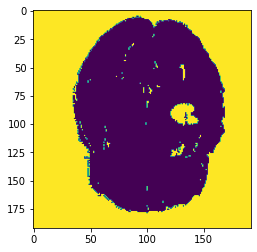

In [7]:
probs, out = torch.max(y_hat, dim=1)
print(out.shape)
plt.imshow(out[0, 70, :, :].cpu())

Crossentropy Loss

In [8]:
criterion = DiceLoss()

In [9]:
print(sample_batch['image'].shape)
print(sample_batch['label'].shape)
print(y_hat.shape)

loss = criterion(y_hat, sample_batch['label'].long().to('cuda:0'))
loss

torch.Size([2, 4, 155, 192, 192])
torch.Size([2, 155, 192, 192])
torch.Size([2, 4, 155, 192, 192])


tensor(3.8146, grad_fn=<DivBackward0>)

Training loop: Overfit to one sample

In [10]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
# training loop
epochs = 300
losses = []
for epoch in range(epochs):
    # get output
    voxel_logits_batch = model.forward(sample_batch['image'].to('cuda:0'))
    
    # get loss
    loss = criterion(voxel_logits_batch, sample_batch['label'].long().to('cuda:0'))
    del voxel_logits_batch
    losses.append(loss)
    
    # backprop loss
    optim.zero_grad()
    loss.backward()
    optim.step()

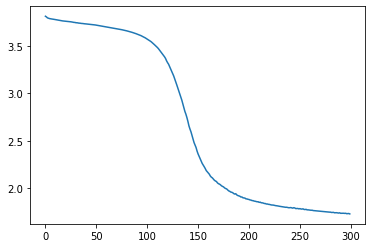

In [12]:
losses_array = [l.cpu().detach().numpy() for l in losses]
plt.plot(losses_array)

In [13]:
print(losses_array)

[array(3.81456, dtype=float32), array(3.8075616, dtype=float32), array(3.7974532, dtype=float32), array(3.7936702, dtype=float32), array(3.7900014, dtype=float32), array(3.7875009, dtype=float32), array(3.7859497, dtype=float32), array(3.7845263, dtype=float32), array(3.7827387, dtype=float32), array(3.7807457, dtype=float32), array(3.7787056, dtype=float32), array(3.7767458, dtype=float32), array(3.774667, dtype=float32), array(3.7724755, dtype=float32), array(3.770249, dtype=float32), array(3.7684646, dtype=float32), array(3.7667084, dtype=float32), array(3.7651, dtype=float32), array(3.7636752, dtype=float32), array(3.7625732, dtype=float32), array(3.7616072, dtype=float32), array(3.7606025, dtype=float32), array(3.7596202, dtype=float32), array(3.7585878, dtype=float32), array(3.757275, dtype=float32), array(3.755798, dtype=float32), array(3.7542534, dtype=float32), array(3.751956, dtype=float32), array(3.7494037, dtype=float32), array(3.749147, dtype=float32), array(3.745885, dtyp

Predict

In [14]:
voxel_logits_batch = model.forward(sample_batch['image'].to('cuda:0'))

In [15]:
voxel_probs_batch = model.sm(voxel_logits_batch)
voxel_probs_batch.shape

torch.Size([2, 4, 155, 192, 192])

In [16]:
print(voxel_probs_batch[0, 0])

tensor([[[0.4604, 0.5754, 0.5754,  ..., 0.5754, 0.5754, 0.4779],
         [0.6211, 0.7815, 0.7815,  ..., 0.7815, 0.7815, 0.6161],
         [0.6211, 0.7815, 0.7815,  ..., 0.7815, 0.7815, 0.6161],
         ...,
         [0.6211, 0.7815, 0.7815,  ..., 0.7815, 0.7815, 0.6161],
         [0.6211, 0.7815, 0.7815,  ..., 0.7815, 0.7815, 0.6161],
         [0.5123, 0.6558, 0.6558,  ..., 0.6558, 0.6558, 0.4762]],

        [[0.6067, 0.7937, 0.7937,  ..., 0.7937, 0.7937, 0.6532],
         [0.7992, 0.9477, 0.9477,  ..., 0.9477, 0.9477, 0.8068],
         [0.7992, 0.9477, 0.9477,  ..., 0.9477, 0.9477, 0.8068],
         ...,
         [0.7992, 0.9477, 0.9477,  ..., 0.9477, 0.9477, 0.8068],
         [0.7992, 0.9477, 0.9477,  ..., 0.9477, 0.9477, 0.8068],
         [0.6455, 0.8113, 0.8113,  ..., 0.8113, 0.8113, 0.6166]],

        [[0.6067, 0.7937, 0.7937,  ..., 0.7937, 0.7937, 0.6532],
         [0.7992, 0.9477, 0.9477,  ..., 0.9477, 0.9477, 0.8068],
         [0.7992, 0.9477, 0.9477,  ..., 0.9477, 0.9477, 0.

In [17]:
probs, out = torch.max(voxel_probs_batch, dim=1)
out.shape

torch.Size([2, 155, 192, 192])

In [18]:
out.sum()

tensor(331446, device='cuda:0')

prediction:


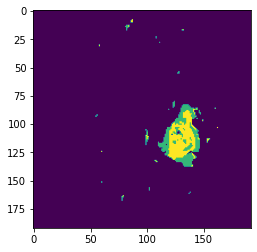

In [22]:
print('prediction:')
plt.imshow(out[0, 80, :, :].cpu())

label:


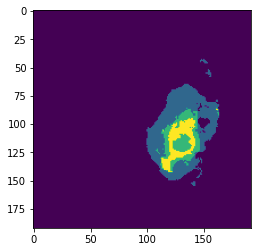

In [23]:
print('label:')
plt.imshow(sample_batch['label'][0, 80, :, :].cpu())

<Figure size 432x288 with 0 Axes>

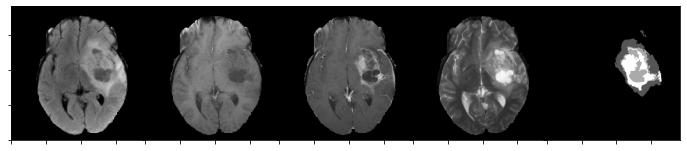

In [21]:
plot_batch(sample_batch, 1)